In [1]:
import torch
import numpy as np
import time
from tqdm import tqdm
from matplotlib import pyplot as plt
from datasets import load_dataset
from transformers import (
    Gemma2ForCausalLM,
    AutoTokenizer,
    HybridCache,
    LlamaForCausalLM,
    LlamaTokenizerFast,
    GPT2LMHeadModel,
    GPT2TokenizerFast,
)


device = "mps"

/Users/aszab/EDU/CAM/modules/L46/project/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model_path = "/Users/aszab/repos/models/gpt2"
model = GPT2LMHeadModel.from_pretrained(model_path).to(device)

tokenizer = GPT2TokenizerFast.from_pretrained(model_path)

if model.config.pad_token_id is None:
    model.config.pad_token_id = model.config.eos_token_id

In [2]:
model_path = "/Users/aszab/repos/models/Llama-3.2-1B"
model = LlamaForCausalLM.from_pretrained(model_path).to(device)

tokenizer = LlamaTokenizerFast.from_pretrained(model_path)

if model.config.pad_token_id is None:
    model.config.pad_token_id = model.config.eos_token_id

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'PreTrainedTokenizerFast'. 
The class this function is called from is 'LlamaTokenizerFast'.
You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama_fast.LlamaTokenizerFast'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565 - if you loaded a llama tokenizer from a GGUF file you can ignore this message.


In [3]:
model_path = "/Users/aszab/repos/models/gemma-2-2b"
model = Gemma2ForCausalLM.from_pretrained(model_path).to(device)

tokenizer = AutoTokenizer.from_pretrained(model_path)

Loading checkpoint shards: 100%|██████████| 3/3 [00:00<00:00,  7.81it/s]


In [3]:
inputs = tokenizer("Hello, my dog is cute and", return_tensors="pt").to(device)

outputs = model(
    **inputs,
    # pad_token_id=model.config.pad_token_id
    labels=inputs["input_ids"],
)
past_key_values = outputs.past_key_values
pred_token_idx = outputs.logits[:, -1, :].argmax(dim=-1).unsqueeze(1)

In [143]:
outputs.loss

tensor(4.6559, device='mps:0', grad_fn=<NllLossBackward0>)

In [144]:
pred_token_idx

tensor([[590]], device='mps:0')

In [4]:
test = load_dataset(
    "wikitext", "wikitext-2-raw-v1", split="test", cache_dir="~/repos/datasets"
)
encodings = tokenizer("\n\n".join(test["text"]), return_tensors="pt")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Token indices sequence length is longer than the specified maximum sequence length for this model (289077 > 131072). Running this sequence through the model will result in indexing errors


In [4]:
past_key_values[0][0].shape

NameError: name 'past_key_values' is not defined

### Dense Attention, Window Attention, Sink Attention (`broken` - without positional encoding shift!)

- For dense attention set `kv_cache_size=-1`, `sink_attn_tks=0`.
- For window attention set `kv_cache_size` to desired max cache length value and `sink_attn_tks=0`.
- For sink attention set both `kv_cache_size` and `sink_attn_tks` to desired values.

`chunk_len` specifies the maximum length of an evaluation sequence. E.g. `chunk_len=5` computes over `A B C D E` F G H I J K

`num_passes` specifies the max number of PPL computations over a sequence of length `chunk_len`. 

`shift_len` specifies the number of tokens the main sequence is shifted by to compute perplexity for the next pass.

E.g. `num_passes=3, chunk_len=5, shift_len=2` computes over:
- `A B C D E` F G H I J K
- A B `C D E F G` H I J K
- A B C D `E F G H I` J K


In [10]:
print(encodings.input_ids[:, :10])

max_seq_len = encodings.input_ids.size(1)

num_passes = 1
chunk_len = 1200
shift_len = 50

kv_cache_size = 256  # -1 means infinite cache
sink_attn_tks = 4

assert num_passes * chunk_len <= max_seq_len
seq_len = shift_len * num_passes
print(f"chunk_len: {chunk_len}")

global_nlls = []
global_generation_time = []
global_past_key_values_size = []
loss_fn = torch.nn.CrossEntropyLoss(reduction="none")


for begin_idx in range(0, seq_len, shift_len):
    end_idx = min(begin_idx + chunk_len, max_seq_len)
    print(f"{begin_idx=}, {end_idx=}")

    pbar = tqdm(range(begin_idx, end_idx - 1))

    if isinstance(model, Gemma2ForCausalLM):
        past_key_values = HybridCache(
            config=model.config,
            batch_size=1,
            max_cache_len=chunk_len,
            device=model.device,
            dtype=model.dtype,
        )
    else:
        past_key_values = None

    nlls = []
    generation_time = []
    past_key_values_size = []

    for idx in pbar:
        input_ids = encodings.input_ids[:, idx : idx + 1].to(device)
        with torch.no_grad():

            start_time = time.time()
            outputs = model(
                input_ids,
                past_key_values=past_key_values,
                use_cache=True,
            )

            generation_time.append(time.time() - start_time)

            logits = outputs.logits.view(-1, model.config.vocab_size)
            label = encodings.input_ids[:, idx + 1 : idx + 2].to(logits.device).view(-1)
            neg_log_likelihood = loss_fn(logits, label)
            past_key_values = outputs.past_key_values

            # cache eviction
            if kv_cache_size != -1 and not isinstance(past_key_values, HybridCache):
                if past_key_values[0][0].shape[2] >= kv_cache_size:
                    past_key_values = [
                        [
                            torch.cat(
                                [
                                    param[:, :, 0:sink_attn_tks, :],
                                    param[:, :, -(kv_cache_size - sink_attn_tks) :, :],
                                ],
                                2,
                            )
                            for param in head
                        ]
                        for head in past_key_values
                    ]

            # memory measurements
            if isinstance(model, Gemma2ForCausalLM):
                past_key_values_size.append(
                    sum(
                        sum([p_i.numel() * p_i.element_size() for p_i in p])
                        for p in [
                            *past_key_values.key_cache,
                            *past_key_values.value_cache,
                        ]
                    )
                )

            else:
                past_key_values_size.append(
                    sum(
                        sum([p_i.numel() * p_i.element_size() for p_i in p])
                        for p in past_key_values
                    )
                )

            # clean apple mps cache (for some reason it does not flush automatically)
            if torch.backends.mps.is_available():
                torch.mps.empty_cache()

        nlls.append(neg_log_likelihood)
        pbar.set_description(
            f"nll: {neg_log_likelihood.item():.2f}, ppl: {torch.exp(neg_log_likelihood).item():.2f}"
        )
    global_nlls.append(nlls)
    global_generation_time.append(generation_time)
    global_past_key_values_size.append(past_key_values_size)

tensor([[128000,    271,    284,   8563,    426,  11206,    466,    284,  77425,
           8563]])
chunk_len: 1200
begin_idx=0, end_idx=1200


nll: 7.95, ppl: 2845.39: 100%|██████████| 1199/1199 [00:54<00:00, 22.16it/s]     


### Sliding window with recomputation

In [397]:
print(encodings.input_ids[:, :10])

max_seq_len = encodings.input_ids.size(1)

num_passes = 1
chunk_len = 2048
shift_len = 50
kv_cache_size = 512

assert num_passes * chunk_len <= max_seq_len
seq_len = shift_len * num_passes
print(f"chunk_len: {chunk_len}")

global_nlls = []
global_generation_time = []
global_past_key_values_size = []
loss_fn = torch.nn.CrossEntropyLoss(reduction="none")


for begin_idx in range(0, seq_len, shift_len):
    end_idx = min(begin_idx + chunk_len, max_seq_len)
    print(f"{begin_idx=}, {end_idx=}")

    pbar = tqdm(range(begin_idx, end_idx - 1))

    nlls = []
    generation_time = []
    past_key_values_size = []

    for idx in pbar:
        input_ids = encodings.input_ids[:, max(0, idx - kv_cache_size) : idx + 1].to(
            device
        )
        with torch.no_grad():

            start_time = time.time()
            outputs = model(
                input_ids,
            )

            generation_time.append(time.time() - start_time)

            logits = outputs.logits[:, -1, :]

            label = encodings.input_ids[:, idx + 1 : idx + 2].to(logits.device).view(-1)
            neg_log_likelihood = loss_fn(logits, label)

            # clean apple mps cache (for some reason it does not flush automatically)
            if torch.backends.mps.is_available():
                torch.mps.empty_cache()

        nlls.append(neg_log_likelihood)
        pbar.set_description(
            f"nll: {neg_log_likelihood.item():.2f}, ppl: {torch.exp(neg_log_likelihood).item():.2f}"
        )
    global_nlls.append(nlls)
    global_generation_time.append(generation_time)
    global_past_key_values_size.append(past_key_values_size)

tensor([[ 628,  796, 5199,  347, 2852,  353,  796,  220,  628,  628]])
chunk_len: 2048
begin_idx=0, end_idx=2048


nll: 2.03, ppl: 7.58: 100%|██████████| 2047/2047 [03:42<00:00,  9.18it/s]        


In [11]:
nlls = torch.tensor(global_nlls).mean(dim=0)
past_key_values = torch.tensor(global_past_key_values_size, dtype=torch.float64).mean(
    dim=0
)

In [11]:
past_key_values_size[0]

73728

In [12]:
torch.mps.empty_cache()

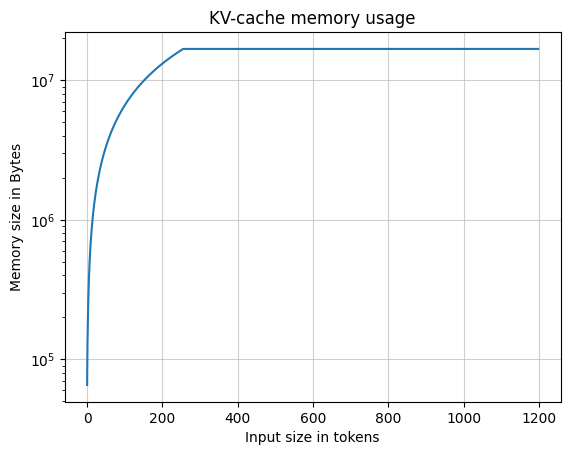

In [12]:
plt.plot(range(len(nlls)), torch.tensor(past_key_values_size))
plt.yscale("log")
plt.title("KV-cache memory usage")
plt.xlabel("Input size in tokens")
plt.ylabel("Memory size in Bytes")
plt.grid(alpha=0.6, zorder=1)

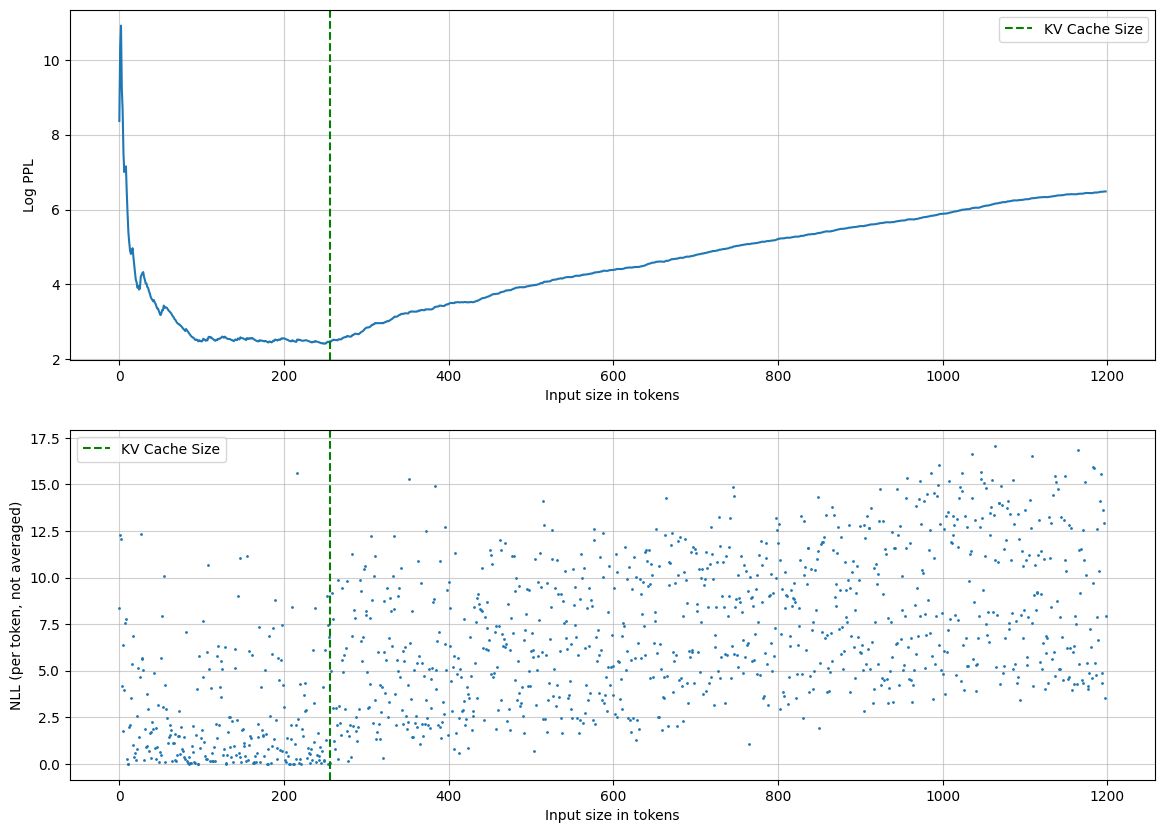

In [13]:
t = nlls

fig, ax = plt.subplots(2, 1, figsize=(14, 10))
ax[0].plot(
    range(len(nlls)),
    [t[: i + 1].mean() for i in range(len(nlls))],
)
# ax[0].axvline(
#     x=model.config.max_position_embeddings,
#     color="red",
#     linestyle="--",
#     alpha=1,
#     label="Context Length",
# )
ax[0].axvline(
    x=kv_cache_size,
    color="green",
    linestyle="--",
    alpha=1,
    label="KV Cache Size",
)
ax[0].set_ylabel("Log PPL")
ax[0].set_xlabel("Input size in tokens")
ax[0].grid(alpha=0.6, zorder=1)
ax[0].legend()

ax[1].plot(
    range(len(nlls)),
    [(t[i]) for i in range(len(nlls))],
    "o",
    # color="red",
    # linewidth=0.1,
    markersize=1,
)
# ax[1].axvline(
#     x=model.config.max_position_embeddings,
#     color="red",
#     linestyle="--",
#     alpha=0.6,
#     label="Context Length",
# )
ax[1].axvline(
    x=kv_cache_size,
    color="green",
    linestyle="--",
    alpha=1,
    label="KV Cache Size",
)
ax[1].set_ylabel("NLL (per token, not averaged)")
ax[1].set_xlabel("Input size in tokens")
ax[1].grid(alpha=0.6, zorder=1)
ax[1].legend()

## GPT2 results

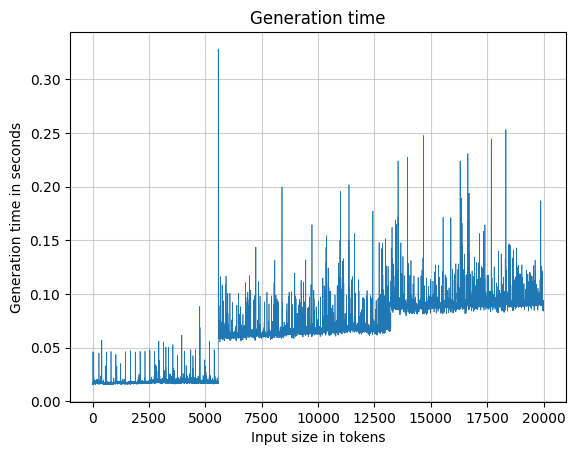

In [138]:
plt.plot(range(len(nlls)), generation_time, linewidth=0.5)
plt.title("Generation time")
plt.xlabel("Input size in tokens")
plt.ylabel("Generation time in seconds")
plt.grid(alpha=0.6, zorder=1)

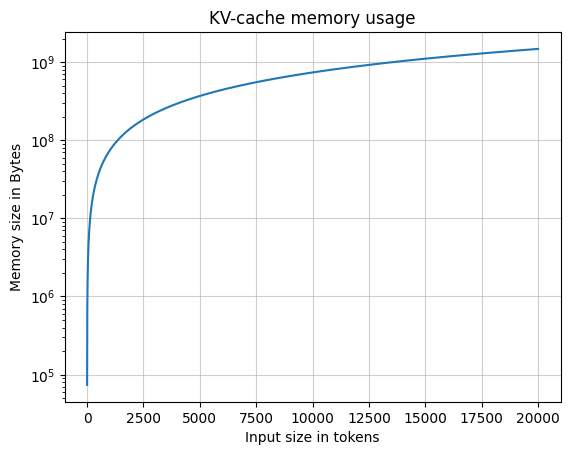

In [139]:
plt.plot(range(len(nlls)), torch.tensor(past_key_values_size))
plt.yscale("log")
plt.title("KV-cache memory usage")
plt.xlabel("Input size in tokens")
plt.ylabel("Memory size in Bytes")
plt.grid(alpha=0.6, zorder=1)

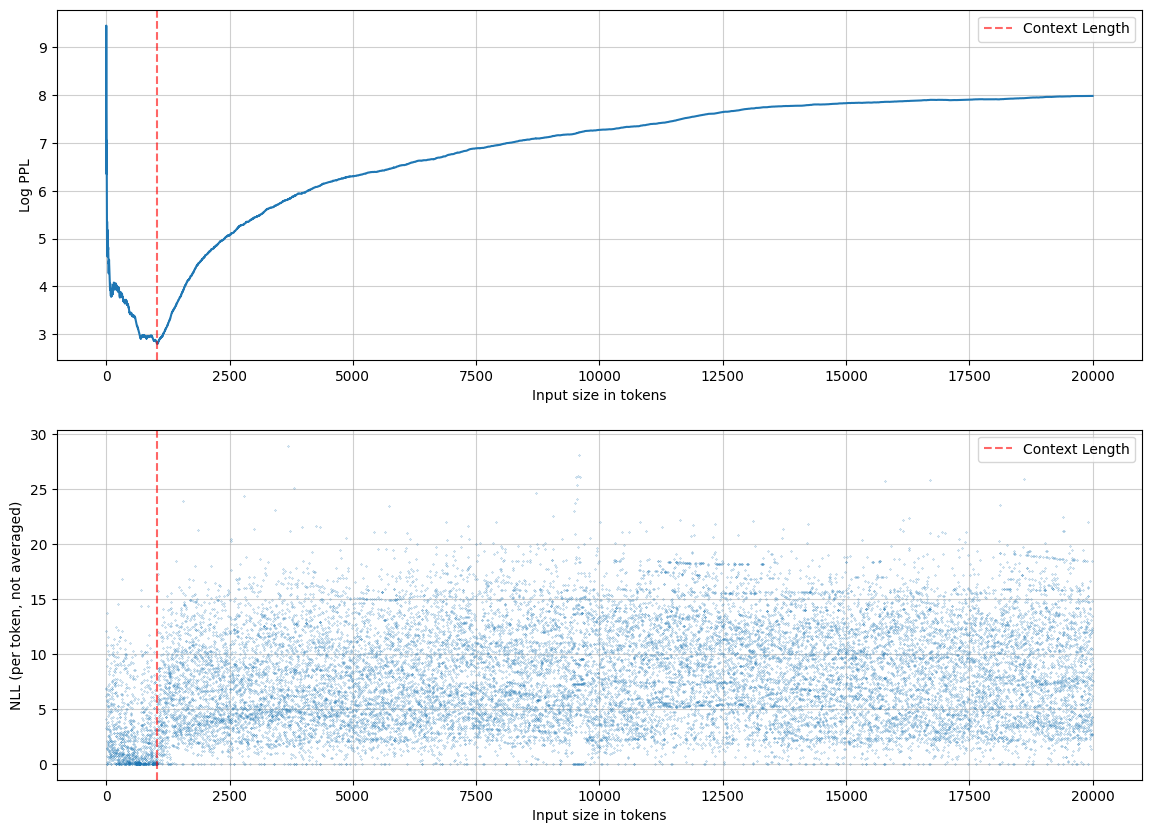

In [135]:
from matplotlib import pyplot as plt

t = torch.stack(nlls).cpu()

fig, ax = plt.subplots(2, 1, figsize=(14, 10))
ax[0].plot(
    range(len(nlls)),
    [t[: i + 1].mean() for i in range(len(nlls))],
)
ax[0].axvline(x=1024, color="red", linestyle="--", alpha=0.6, label="Context Length")
ax[0].set_ylabel("Log PPL")
ax[0].set_xlabel("Input size in tokens")
ax[0].grid(alpha=0.6, zorder=1)
ax[0].legend()

ax[1].plot(
    range(len(nlls)),
    [(t[i]) for i in range(len(nlls))],
    "o",
    # color="red",
    # linewidth=0.1,
    markersize=0.2,
)
ax[1].axvline(x=1024, color="red", linestyle="--", alpha=0.6, label="Context Length")
ax[1].set_ylabel("NLL (per token, not averaged)")
ax[1].set_xlabel("Input size in tokens")
ax[1].grid(alpha=0.6, zorder=1)
ax[1].legend()

## Attention visualisations

In [28]:
from transformers import GPT2LMHeadModel, GPT2TokenizerFast


model_path = "/Users/aszab/repos/models/gpt2"
model = GPT2LMHeadModel.from_pretrained(model_path, output_attentions=True).to(device)

tokenizer = GPT2TokenizerFast.from_pretrained(model_path)

if model.config.pad_token_id is None:
    model.config.pad_token_id = model.config.eos_token_id

/Users/aszab/EDU/CAM/modules/L46/project/venv/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:818: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_attentions` is. When `return_dict_in_generate` is not `True`, `output_attentions` is ignored.
  warnings.warn(


In [29]:
inputs = tokenizer(
    "The dominant sequence transduction models are based on complex recurrent or convolutional neural networks that include an encoder and a decoder.",
    return_tensors="pt",
).to(device)

outputs = model(
    **inputs,
)

In [24]:
inputs = {"input_ids": encodings["input_ids"][:, :128].to(device)}
outputs = model(**inputs)

In [25]:
inputs["input_ids"]

tensor([[128000,    271,    284,   8563,    426,  11206,    466,    284,  77425,
           8563,    426,  11206,    466,    374,    459,   6498,   4632,   1174,
          12707,    323,  34596,  12360,    662,   1283,   1047,    264,   8810,
            571,     12,     31,  40500,   3560,    389,    279,  12707,   4101,
            578,   8766,    304,    220,   1049,     15,    662,   1115,    574,
           8272,    555,    264,  40500,   3560,    304,    279,   1514,   6385,
           2439,   5439,    555,  22021,  77023,   1174,    902,    574,  10887,
            304,    220,   1049,     16,    520,    279,  16591,   7301,  27315,
            662,   1283,   1047,    264,   8810,   3560,    304,    279,  12707,
           4101,  20819,   3842,   1611,    291,    304,    220,   1049,     17,
            662,    763,    220,   1049,     19,    426,  11206,    466,  27212,
            264,   3560,    439,    330,  29517,    330,    304,    279,   9417,
            330,  71166,    

In [20]:
outputs.attentions[0]

torch.Tensor

In [354]:
torch.stack(outputs.attentions).cpu().detach().numpy().shape

(12, 1, 12, 128, 128)

In [30]:
def get_attn_map(
    attn: tuple[torch.Tensor], layer_num: int, head_num: int
) -> np.ndarray:
    """
    Retrieves the attention map for a specified layer and head from the model's attention outputs.

    Args:
        attn (tuple[torch.Tensor]): A tuple of attention tensors from the model's output.attentions.
        layer_num (int): The index of the layer from which to retrieve the attention map.
                         If -1, the attention maps across all layers are averaged.
        head_num (int): The index of the head from which to retrieve the attention map.
                        If -1, the attention maps across all heads are averaged.

    Returns:
        np.ndarray: The attention map for the specified layer and head.
    """
    attn = torch.stack(attn).cpu().detach().numpy()
    if layer_num == -1:
        attn = attn.mean(axis=0, keepdims=True)
        layer_num = 0

    if head_num == -1:
        attn = attn.mean(axis=2, keepdims=True)
        head_num = 0

    attn_map = attn[layer_num, 0, head_num, :, :]

    return attn_map

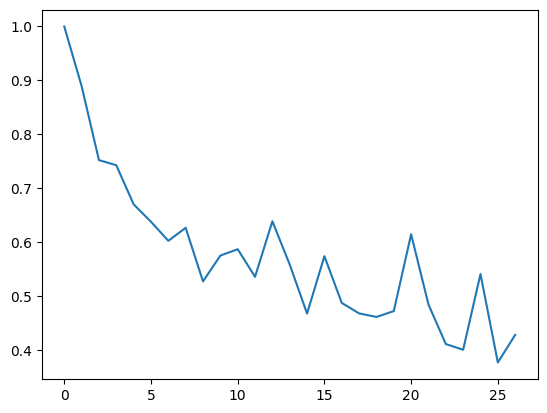

In [32]:
attn_map = get_attn_map(outputs.attentions, -1, -1)
plt.plot(range(attn_map.shape[1]), attn_map[:, 0])

In [36]:
def show_attn(
    attn_map: np.ndarray, token_labels: list[str], log_scale: bool = False
) -> None:
    """
    Visualizes an attention map with token labels.

    Parameters:
        attn_map (np.ndarray): The attention map to visualize. It is expected to be a 2D array.
        token_labels (list[str]): A list of token labels corresponding to the attention map.
        log_scale (bool, optional): If True, applies a logarithmic scale to the attention map values. Defaults to False.

    Returns:
        None
    """
    fn = np.log if log_scale else lambda x: x

    _, ax = plt.subplots(figsize=(8, 8))

    # mask for plotting the bad color for padding tokens (upper triangular part)
    attn_map = np.ma.masked_where(attn_map == 0, attn_map)

    cmap = plt.cm.coolwarm
    cmap.set_bad(color="grey")
    ax.matshow(fn(attn_map), cmap=cmap)

    ax.xaxis.set_label_position("bottom")  # Move x-axis label to the bottom
    ax.xaxis.tick_bottom()  # Ensure ticks are on the bottom
    _ = ax.set_xticks(
        range(len(inputs["input_ids"][0])),
        token_labels,
        fontsize=9,
        rotation=90,
    )
    _ = ax.set_yticks(
        range(len(inputs["input_ids"][0])),
        token_labels,
        fontsize=9,
    )
    ax.set_ylabel("Query token", fontsize=12)
    ax.set_xlabel("Key token", fontsize=12)

/var/folders/zy/tf5h417916z3zcml60nrcxvc0000gn/T/ipykernel_63262/1193795847.py:24: RuntimeWarning: divide by zero encountered in log
  ax.matshow(fn(attn_map), cmap=cmap)


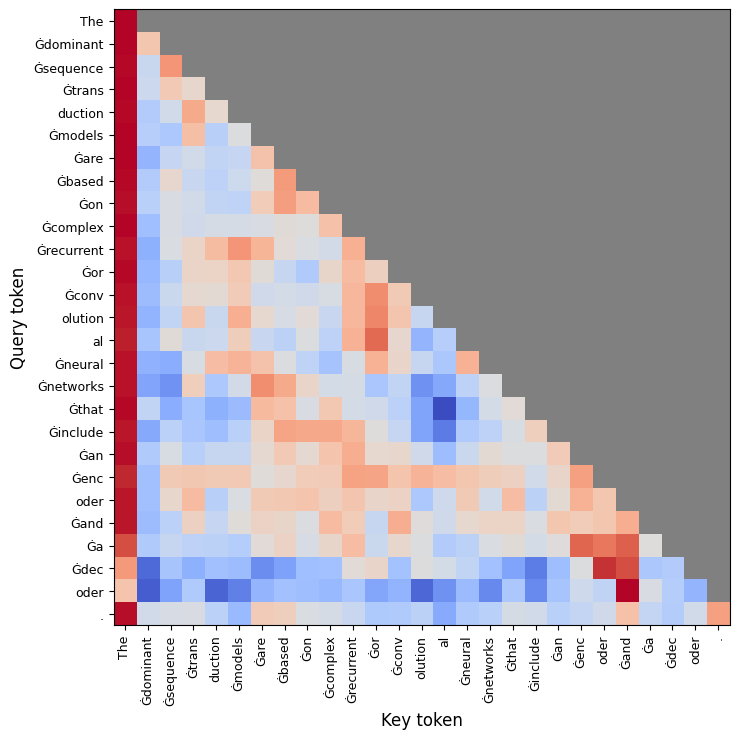

In [37]:
show_attn(
    get_attn_map(outputs.attentions, 5, 0),
    tokenizer.convert_ids_to_tokens(inputs["input_ids"].cpu().detach().numpy()[0]),
    True,
)

In [39]:
def show_attn_layers(attn_map_lst: list[np.ndarray], log_scale: bool = False) -> None:
    """
    Visualizes attention maps for each layer in a grid layout.

    Parameters:
        attn_map_lst (list[np.ndarray]): A list of attention maps, where each attention map is a 2D numpy array.
        log_scale (bool): If True, applies a logarithmic scale to the attention maps for visualization. Default is False.

    Returns:
        None
    """
    fn = np.log if log_scale else lambda x: x

    n_cols = 4
    n_rows = len(attn_map_lst) // n_cols
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(14, 10))

    for i, attn_map in enumerate(attn_map_lst):
        # mask for plotting the bad color for padding tokens (upper triangular part)
        attn_map = np.ma.masked_where(attn_map == 0, attn_map)

        cmap = plt.cm.coolwarm
        cmap.set_bad(color="grey")
        axs[i // n_cols][i % n_cols].matshow(fn(attn_map), cmap=cmap)

        axs[i // n_cols][i % n_cols].xaxis.set_label_position(
            "bottom"
        )  # Move x-axis label to the bottom
        axs[i // n_cols][
            i % n_cols
        ].xaxis.tick_bottom()  # Ensure ticks are on the bottom

        axs[i // n_cols][i % n_cols].set_title(f"Layer {i}")
        axs[i // n_cols][i % n_cols].set_ylabel("Query token", fontsize=10)
        axs[i // n_cols][i % n_cols].set_xlabel("Key token", fontsize=10)
        fig.tight_layout()

/var/folders/zy/tf5h417916z3zcml60nrcxvc0000gn/T/ipykernel_63262/2761506107.py:24: RuntimeWarning: divide by zero encountered in log
  axs[i // n_cols][i % n_cols].matshow(fn(attn_map), cmap=cmap)


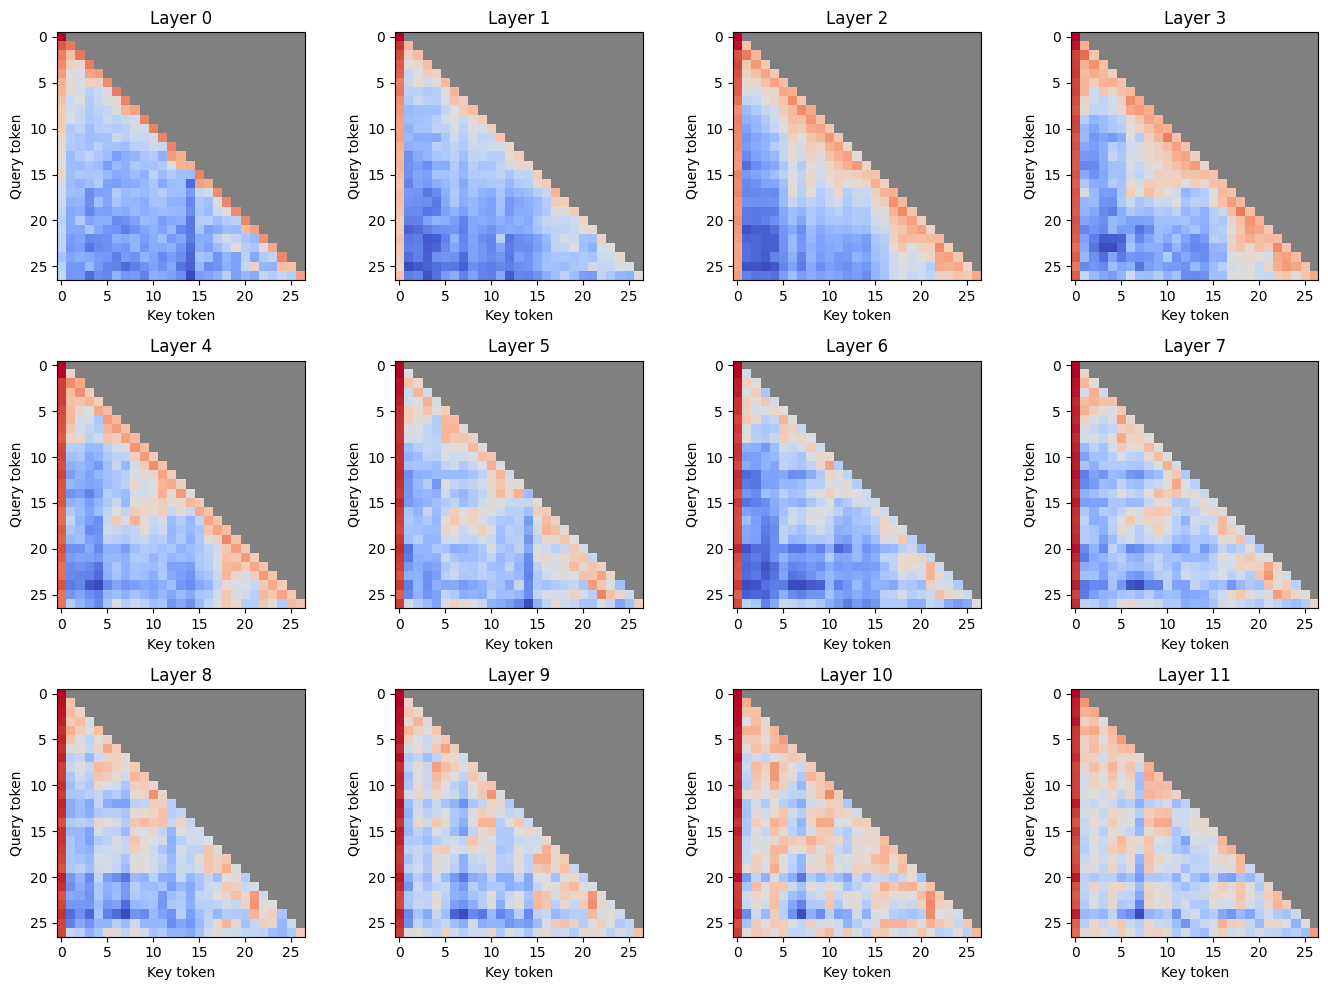

In [41]:
show_attn_layers(
    [get_attn_map(outputs.attentions, i, -1) for i in range(12)], log_scale=True
)